<a href="https://colab.research.google.com/github/Kim-matthew-0422/deeplearning-early-covid-detection-/blob/main/EfficientNETV2L.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi -L
!mkdir ~/.kaggle
from google.colab import files
files.upload()

GPU 0: Tesla T4 (UUID: GPU-f618e073-00cb-5a49-8256-000fc86c8a28)
mkdir: cannot create directory ‘/root/.kaggle’: File exists


Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"etkim422","key":"ba5083a771515c1999a723e17e69eb58"}'}

covid19-radiography-database.zip: Skipping, found more recently modified local copy (use --force to force download)
--2023-01-31 07:43:43--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-31 07:43:43 (115 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



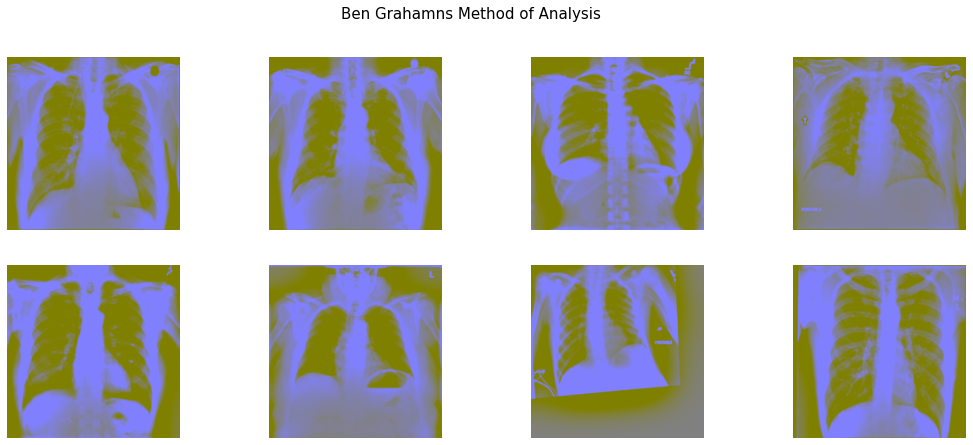

In [2]:
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir
from sklearn.model_selection import train_test_split
unzip_data('covid19-radiography-database.zip')
path = 'COVID-19_Radiography_Dataset'
levels = ['Normal/images', 'COVID/images']
import os
data_dir = os.path.join(path) 
import pandas as pd

data = []
for id, level in enumerate(levels):
    for file in os.listdir(os.path.join(data_dir, level)):
        data.append(['{}/{}'.format(level, file), level])
data = pd.DataFrame(data, columns = ['image_file', 'corona_result'])
data['path'] = path + '/' + data['image_file']
data['corona_result'] = data['corona_result'].map({'Normal/images': 'Negative', 'COVID/images': 'Positive'})
samples = 13808

data.head()
import numpy as np
from keras.preprocessing import image
from PIL import Image
data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((75,75))))

data.head()
all_covid = []
all_normal = []
import random
from glob import glob
all_normal.extend(glob(os.path.join(path, 'Normal/images/*.png')))
all_covid.extend(glob(os.path.join(path, 'COVID/images/*.png')))

random.shuffle(all_normal)
random.shuffle(all_covid)

images = all_normal[:50] + all_covid[:50]
from matplotlib import pyplot as plt
import cv2
fig = plt.figure(figsize = (18, 7))
fig.suptitle("Ben Grahamns Method of Analysis", fontsize = 15)
columns = 4; rows = 2

for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

In [3]:
all_data = []


for i in range(len(data)):
  image = cv2.imread(data['path'][i])
  image = cv2.resize(image, (70,70))
  label = 1 if data['corona_result'][i] == 'Positive' else 0 
  all_data.append([image, label])

x = []
y = []

for image, label in all_data:
    x.append(image)
    y.append(label)

# Converting to Numpy Array    
x = np.array(x)
y = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42)

print(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape)

(9941, 70, 70, 3) (2762, 70, 70, 3) (1105, 70, 70, 3) (9941,) (2762,) (1105,)


In [4]:
from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0

In [5]:
base_model = EfficientNetV2B0(input_shape = (70,70,3),
                         include_top = False)
for layer in base_model.layers:
    layer.trainable = False

In [6]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
EFF_model = Sequential()
EFF_model.add(base_model)
EFF_model.add(layers.Flatten())
EFF_model.add(layers.Dense(units = 16, activation = 'relu'))
EFF_model.add(layers.Dropout(0.2))
EFF_model.add(layers.Dense(units = 2))

EFF_model.compile(optimizer = 'adam',
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                  metrics = ['accuracy'])

In [7]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)
history_EFF = EFF_model.fit(x_train, y_train, 
                        epochs = 50, batch_size = 256,  
                        validation_data = (x_val, y_val), 
                        callbacks = [es])

Epoch 1/50
39/39 [==============================] - 19s 134ms/step - loss: 0.4655 - accuracy: 0.7729 - val_loss: 0.3110 - val_accuracy: 0.8995
Epoch 2/50
39/39 [==============================] - 3s 68ms/step - loss: 0.3368 - accuracy: 0.8798 - val_loss: 0.2639 - val_accuracy: 0.9222
Epoch 3/50
39/39 [==============================] - 3s 68ms/step - loss: 0.2992 - accuracy: 0.9056 - val_loss: 0.2377 - val_accuracy: 0.9339
Epoch 4/50
39/39 [==============================] - 3s 68ms/step - loss: 0.2783 - accuracy: 0.9260 - val_loss: 0.2274 - val_accuracy: 0.9493
Epoch 5/50
39/39 [==============================] - 3s 68ms/step - loss: 0.2521 - accuracy: 0.9331 - val_loss: 0.2132 - val_accuracy: 0.9475
Epoch 6/50
39/39 [==============================] - 3s 70ms/step - loss: 0.2373 - accuracy: 0.9446 - val_loss: 0.1994 - val_accuracy: 0.9520
Epoch 7/50
39/39 [==============================] - 3s 68ms/step - loss: 0.2247 - accuracy: 0.9471 - val_loss: 0.1891 - val_accuracy: 0.9538
Epoch 8/50


In [8]:
yp_train = EFF_model.predict(x_train)
yp_train = np.argmax(yp_train, axis = 1)

yp_val = EFF_model.predict(x_val)
yp_val = np.argmax(yp_val, axis = 1)

yp_test = EFF_model.predict(x_test)
yp_test = np.argmax(yp_test, axis = 1)

def evaluation_parametrics(name, y_train, yp_train, y_val, yp_val, y_test, yp_test):
    
    print("\n-----------------------------{}-----------------------------\n".format(name))
    
    cm_train = confusion_matrix(y_train, yp_train)
    t1 = ConfusionMatrixDisplay(cm_train)
    s1 = round((cm_train[0,0]/(cm_train[0,0] + cm_train[0,1])),4)
    
    print("Classification Report for Train Data\n")
    print(classification_report(y_train, yp_train)) 
    print("--------------------------------------------------------------------------")
    print("Recall on Train Data: ", round(recall_score(y_train, yp_train),4))
    print("Specificity on Train Data: ", s1)
    print("Accuracy on Train Data: ", round(accuracy_score(y_train, yp_train),4))
    print("Precision on Train Data: ", round(precision_score(y_train, yp_train),4))
    print("F1 Score on Train Data: ", round(f1_score(y_train, yp_train),4))
    print("--------------------------------------------------------------------------")
       
    cm_val = confusion_matrix(y_val, yp_val)
    t2 = ConfusionMatrixDisplay(cm_val)
    s2 = round((cm_val[0,0]/(cm_val[0,0] + cm_val[0,1])),4)
    
    print("\nClassification Report for Validation Data\n")
    print(classification_report(y_val, yp_val))   
    print("--------------------------------------------------------------------------")
    print("Recall on Val Data: ", round(recall_score(y_val, yp_val),4))
    print("Specificity on Val Data: ", s2)
    print("Accuracy on Val Data: ", round(accuracy_score(y_val, yp_val),4))
    print("Precision on Val Data: ", round(precision_score(y_val, yp_val),4))
    print("F1 Score on Val Data: ", round(f1_score(y_val, yp_val),4))
    print("--------------------------------------------------------------------------")

    cm_test = confusion_matrix(y_test, yp_test)
    t3 = ConfusionMatrixDisplay(cm_test)
    s3 = round((cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])),4)
    
    print("\nClassification Report for Test Data\n")
    print(classification_report(y_test, yp_test))   
    print("--------------------------------------------------------------------------")
    print("Recall on Test Data: ", round(recall_score(y_test, yp_test), 4))
    print("Specificity on Test Data: ", s3)
    print("Accuracy on Test Data: ", round(accuracy_score(y_test, yp_test), 4))
    print("Precision on Test Data: ", round(precision_score(y_test, yp_test), 4))
    print("F1 Score Test Data: ", round(f1_score(y_test, yp_test), 4))
    print("--------------------------------------------------------------------------")
    
    t1.plot()
    t2.plot()   
    t3.plot()

87/87 [==============================] - 1s 15ms/step



-----------------------------Convolution Neural Network-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7287
           1       1.00      1.00      1.00      2654

    accuracy                           1.00      9941
   macro avg       1.00      1.00      1.00      9941
weighted avg       1.00      1.00      1.00      9941

--------------------------------------------------------------------------
Recall on Train Data:  0.9989
Specificity on Train Data:  0.9986
Accuracy on Train Data:  0.9987
Precision on Train Data:  0.9962
F1 Score on Train Data:  0.9976
--------------------------------------------------------------------------

Classification Report for Validation Data

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       844
           1       0.93      0.94      0.94       261

    accuracy                

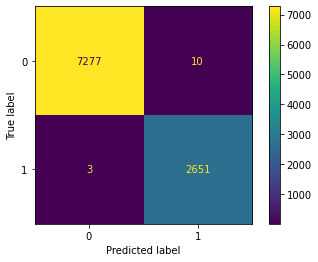

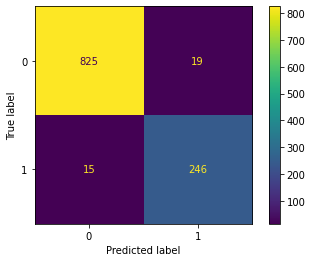

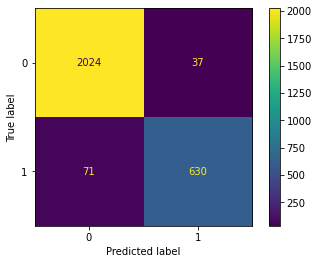

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score
evaluation_parametrics("Convolution Neural Network", y_train, yp_train, y_val, yp_val, y_test, yp_test)